# <font  color = "#0093AF">Quadrupolar phenomena</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter3/Ch3_Quad.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

SLEEPY can be used to simulate quadrupolar nuclei, both in the rotating and lab frames. We start with an example on deuterium in exchange.

Membrane properties are often characterized by measurement of residual dipole or quadrupole couplings. For example, the $^2$H quadrupole spliting (difference between maxima) in a membrane aliphatic chain is approximately 167 kHz when rigid, but symmetric rotation about the membrane normal already reduces that value by half. Additional motion reduces this value further, yielding order parameters (scaling factors) from 0.01-0.2 in pure POPC.

In more complex membranes, it can be the case that lipids exchange environments, leading to complex lineshapes coming from both environments, with potential broadening depending on the rate of exchange. Here, we simulate a deuterium nucleus, with exchange of the quadrupole coupling.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system
We start with a reference peak-to-peak width (`DelPP`) of 167 kHz, and scale it with order parameters of 0.15 and 0.3.

In [3]:
ex0=sl.ExpSys(v0H=600,Nucs='2H',vr=0,pwdavg='bcr400')
ex0.set_inter('quadrupole',i=0,DelPP=167e3*.15)
ex1=ex0.copy()
ex1.set_inter('quadrupole',i=0,DelPP=167e3*.3)

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=5e-5,p1=.5))

## Propagate the system, plot

State-space reduction: 18->4


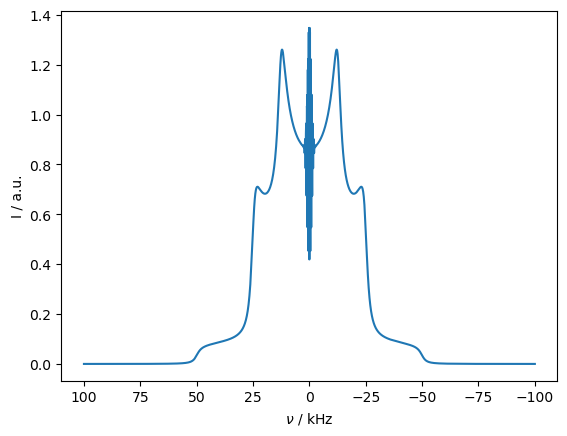

In [5]:
seq=L.Sequence(Dt=5e-6)
rho=sl.Rho('2Hx','2Hp')

rho.DetProp(seq,n=4096)
rho.apod_pars['WDW']='em'
rho.apod_pars['LB']=100
_=rho.plot(FT=True,apodize=True)

Note the behavior at the central frequency comes from couplings oriented near the magic angle, where the change in the size of the quadrupole coupling has little influence on the resonance frequency, and so very little relaxation is induced at these orientations. 

If we change the exchange rate, we can obtain two well-separated lineshapes (slow exchange) or a single well-resolved lineshape (fast exchange).

State-space reduction: 18->4
State-space reduction: 18->4


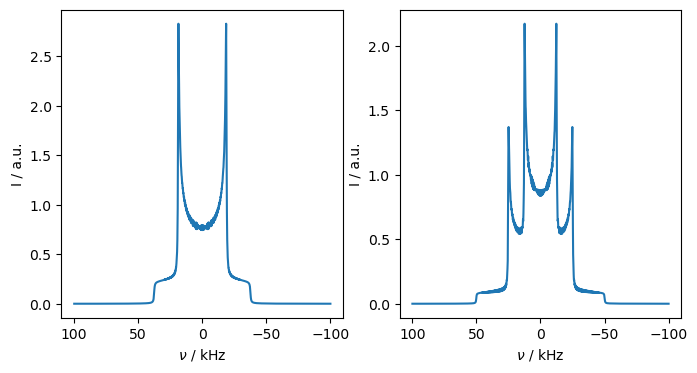

In [5]:
#seq=L.Sequence(Dt=5e-6)

fig,ax=plt.subplots(1,2,figsize=[8,4])

L.kex=sl.Tools.twoSite_kex(tc=1e-7)

rho=sl.Rho('2Hx','2Hp')

rho.DetProp(seq,n=4096)
rho.apod_pars['WDW']='em'
rho.apod_pars['LB']=500
rho.plot(FT=True,apodize=True,ax=ax[0])

L.kex=sl.Tools.twoSite_kex(tc=1e-1)

rho=sl.Rho('2Hx','2Hp')

rho.DetProp(seq,n=4096)
rho.apod_pars['WDW']='em'
rho.apod_pars['LB']=500
_=rho.plot(FT=True,apodize=True,ax=ax[1])

## Second order quadrupolar broadening in the lab frame
Half-integer spins produce a narrow peak in the middle of the quadrupolar spectrum. However, this peak is broadened by the second-order quadrupole coupling. Simulating this broadening presents a challenge, because it is a rank-4 tensor, making its transformation under rotation different than the rank-2 tensors that most simulation packages are setup to handle. However, if the quadrupolar interaction is simulated in the lab frame, the second order quadrupole coupling arises naturally. We demonstrate here, with one simulation in the rotating frame, and one in the lab frame.

In [6]:
exRF=sl.ExpSys(250,Nucs='17O',vr=60000,pwdavg=6,n_gamma=32)
exRF.set_inter('quadrupole',i=0,delta=150000)
seqRF=exRF.Liouvillian().Sequence()
rhoRF=sl.Rho('17Ox','17Op')
rhoRF.DetProp(seqRF,n=16000,n_per_seq=32)

exLF=sl.ExpSys(250,Nucs='17O',vr=60000,LF=True,pwdavg=6,n_gamma=32)
exLF.set_inter('quadrupole',i=0,delta=150000)
seqLF=exLF.Liouvillian().Sequence()
rhoLF=sl.Rho('17Ox','17Op')
_=rhoLF.DetProp(seqLF,n=16000,n_per_seq=32)

State-space reduction: 36->5
Prop: 32 steps per every 1 rotor period
Prop: 32 steps per every 1 rotor period


Note that if we observe transverse magnetization when it is in the lab frame, it will oscillate near the Larmor frequency of the spin. The center frequency of the spectrum will then be incorrect. This may be corrected by downmixing the signal before plotting (`rho.downmix()`).

Already downmixed


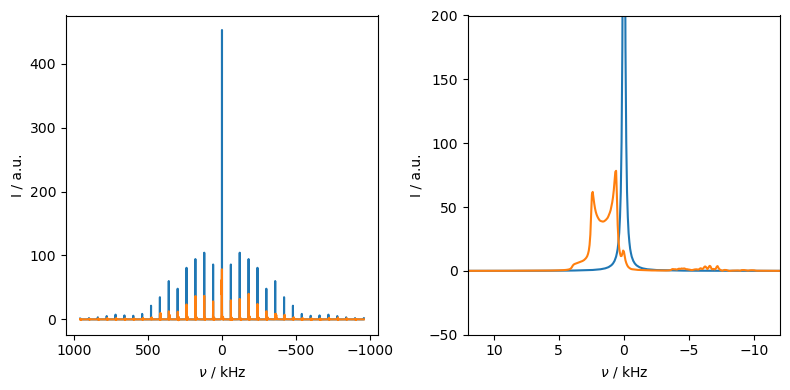

In [21]:
fig,ax=plt.subplots(1,2,figsize=[8,4])
rhoRF.plot(FT=True,apodize=True,axis='kHz',ax=ax[0])
rhoRF.plot(FT=True,apodize=True,axis='kHz',ax=ax[1])
rhoLF.downmix()
rhoLF.plot(FT=True,apodize=True,axis='kHz',ax=ax[0])
rhoLF.plot(FT=True,apodize=True,axis='kHz',ax=ax[1])
ax[1].set_xlim([12,-12])
ax[1].set_ylim([-50,200])
fig.tight_layout()

A benefit of high-field magnets is that they narrow the second-order quadrupole broadening. We demonstrate that here, by comparing the spectrum from 250 MHz to that using a 1.2 GHz magnet.

In [22]:
exHF=sl.ExpSys(1200,Nucs='17O',vr=60000,LF=True,pwdavg=6,n_gamma=32)
exHF.set_inter('quadrupole',i=0,delta=150000)
seqHF=exHF.Liouvillian().Sequence()
rhoHF=sl.Rho('17Ox','17Op')
rhoHF.DetProp(seqHF,n=16000,n_per_seq=32)
_=rhoHF.downmix()

Prop: 32 steps per every 1 rotor period


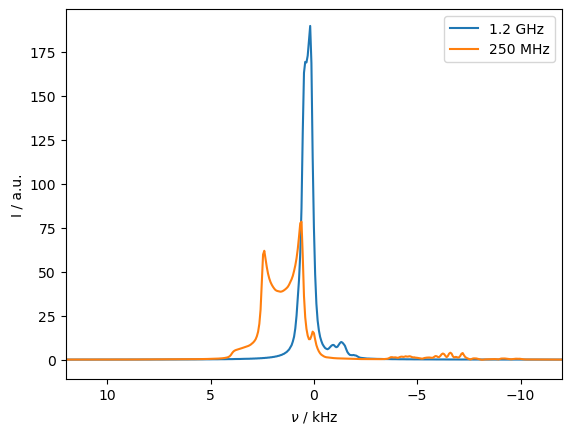

In [23]:
ax=rhoHF.plot(FT=True,apodize=True,axis='kHz')
rhoLF.plot(FT=True,apodize=True,axis='kHz',ax=ax)
ax.legend(['1.2 GHz','250 MHz'])
_=ax.set_xlim([12,-12])